In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import random

In [2]:
import gdown

file_id = "1RQMtMCFHCrkMIJklYEcZ9oeB_WODpgjLr9yNIlQucC8"
filename = "violence_text_preprocessed.xlsx"

url = f"https://docs.google.com/spreadsheets/d/{file_id}/export?format=xlsx"

# Download
gdown.download(url, filename, quiet=False)

df = pd.read_excel(filename)

df.head()

/usr/local/lib/python3.12/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://docs.google.com/spreadsheets/d/1RQMtMCFHCrkMIJklYEcZ9oeB_WODpgjLr9yNIlQucC8/export?format=xlsx
To: /kaggle/working/violence_text_preprocessed.xlsx
610kB [00:00, 21.5MB/s]


Clean_Text  label
0  যে দেশে সন্ত্রাসরা দেশ চালায়সে দেশে শান্তি কিভ...      1
1  এই বিচার শেষ বিচার নয়আসল বিচার হবে আল্লাহর আদা...      0
2  আরব দেশগুলোকে বলব ভারতের সাথে সব ব্যবসা বাণিজ্...      2
3                                    দেশটা সুস্থ নাই      0
4  আপনার কথা দুঃখ জনক আগে বিডিও থাকলে কেন ধরা হলন...      0

In [3]:
df.shape

(11933, 2)

In [4]:
X = df["Clean_Text"]
y = df["label"]

### **Stratified Train / Val / Test Split**

In [5]:
# First split: Train (70%) + Temp (30%)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_idx, temp_idx in sss1.split(X, y):
    X_train, X_temp = X.iloc[train_idx], X.iloc[temp_idx]
    y_train, y_temp = y.iloc[train_idx], y.iloc[temp_idx]

# Second split: Validation (15%) + Test (15%)

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_idx, test_idx in sss2.split(X_temp, y_temp):
    X_val, X_test = X_temp.iloc[val_idx], X_temp.iloc[test_idx]
    y_val, y_test = y_temp.iloc[val_idx], y_temp.iloc[test_idx]

print("Train:", y_train.value_counts())
print("Validation:", y_val.value_counts())
print("Test:", y_test.value_counts())

Train: label
0    3606
1    2735
2    2012
Name: count, dtype: int64
Validation: label
0    773
1    586
2    431
Name: count, dtype: int64
Test: label
0    773
1    586
2    431
Name: count, dtype: int64


In [6]:
train_df = pd.DataFrame({"text": X_train, "label": y_train})
val_df   = pd.DataFrame({"text": X_val,   "label": y_val})
test_df  = pd.DataFrame({"text": X_test,  "label": y_test})

In [7]:
print('train data: ',train_df.shape)
print('validation data: ',val_df.shape)
print('test data: ',test_df.shape)

train data:  (8353, 2)
validation data:  (1790, 2)
test data:  (1790, 2)


In [8]:
import transformers
print(transformers.__version__)

4.57.1


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

2026-01-05 07:22:52.159135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767597772.353522      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767597772.407798      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767597772.873269      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767597772.873304      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767597772.873307      55 computation_placer.cc:177] computation placer alr

In [10]:
# Load tokenizer
MODEL_NAME = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [11]:
# # Load model
# model = AutoModelForSequenceClassification.from_pretrained(
#     MODEL_NAME,
#     num_labels=3  # classification head is adjusted for 3 classes
# )

###  Pre-process the text using the BanglaBERT tokenizer and format it into a PyTorch dataset.

In [12]:
# create dataset classes

MAX_LEN = 256  # max token length for Bangla sentences

class ViolenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=MAX_LEN):
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            # padding='max_length',
            padding=False,
            truncation=True,
            return_tensors='pt',
            add_special_tokens=True
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create dataset objects
train_dataset = ViolenceDataset(train_df, tokenizer)
val_dataset = ViolenceDataset(val_df, tokenizer)


In [13]:
# # Compute class weights

# class_weights = compute_class_weight(
#     class_weight='balanced',
#     # class_weights = torch.tensor([1.0, 1.6, 1.4]).to(model.device),
#     classes=np.unique(train_df['label']),
#     y=train_df['label']
# )

# class_weights = torch.tensor(class_weights, dtype=torch.float)

# class_weights = torch.tensor([1.0, 1.25, 1.0]).to(device)
class_weights = torch.tensor([1.0, 1.25, 1.0])



In [14]:
# Define compute_metrics function

# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = np.argmax(pred.predictions, axis=1)
#     acc = accuracy_score(labels, preds)
#     f1 = f1_score(labels, preds)
#     precision = precision_score(labels, preds)
#     recall = recall_score(labels, preds)
#     return {
#         'accuracy': acc,
#         'f1': f1,
#         'precision': precision,
#         'recall': recall
#     }


import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }


In [15]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3  # classification head is adjusted for 3 classes
)

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **LoRA Config**

In [16]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=32,
    lora_alpha=64,
    lora_dropout=0.1,
    target_modules=["query", 
        "key", 
        "value", 
        "dense", 
        "intermediate.dense", 
        "output.dense"],
    bias="none"
)

#Wrap Model with LoRA
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 5,901,315 || all params: 116,520,966 || trainable%: 5.0646


# HMS Edition Fine Tuning

In [18]:
# Define TrainingArguments

# MY MODEL
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=8,
    max_steps=-1,

    learning_rate=1.5e-4,
    weight_decay=0.01,
    warmup_ratio=0.1,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    eval_strategy="steps",
    eval_steps=200,

    logging_strategy="steps",
    logging_steps=20,
    logging_first_step=True,

    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,

    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    # fp16=torch.cuda.is_available(),
    fp16 = True,
    max_grad_norm=1.0,

    report_to="none",
    disable_tqdm=False,
)

In [19]:
# Custom loss with class weights

# from torch.nn import CrossEntropyLoss

# class WeightedTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.get("labels").long()
#         outputs = model(**inputs)
#         logits = outputs.get("logits")
#         loss_fn = CrossEntropyLoss(weight=class_weights.to(logits.device))
#         loss = loss_fn(logits, labels)
#         return (loss, outputs) if return_outputs else loss


from torch.nn import CrossEntropyLoss
from transformers import Trainer

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").long()
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fn = CrossEntropyLoss(
            weight=class_weights.to(logits.device)
        )
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [20]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)


In [21]:
# Initialize Trainer

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_55/3201740747.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [22]:
# training_args = training_args.replace(max_steps=50)
trainer.train()

TrainOutput(global_step=2096, training_loss=0.3286732347639462, metrics={'train_runtime': 504.4629, 'train_samples_per_second': 132.466, 'train_steps_per_second': 4.155, 'total_flos': 2267515151050716.0, 'train_loss': 0.3286732347639462, 'epoch': 8.0})

In [23]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.8113031387329102, 'eval_accuracy': 0.8284916201117318, 'eval_f1_macro': 0.8261398082261177, 'eval_precision_macro': 0.8273505068333816, 'eval_recall_macro': 0.8250264707791279, 'eval_runtime': 5.5664, 'eval_samples_per_second': 321.571, 'eval_steps_per_second': 10.06, 'epoch': 8.0}


In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

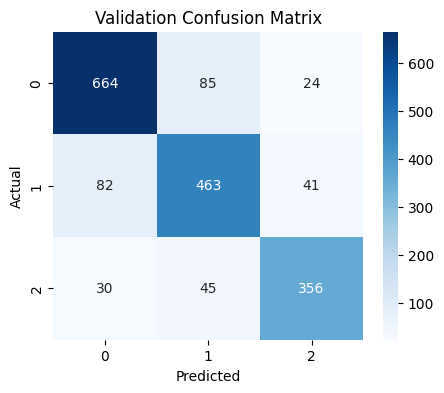

In [25]:
# Get validation predictions
val_predictions = trainer.predict(val_dataset)
val_preds = np.argmax(val_predictions.predictions, axis=1)
val_labels = val_predictions.label_ids

# Compute confusion matrix
cm_val = confusion_matrix(val_labels, val_preds)

# Display
plt.figure(figsize=(5,4))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()

In [26]:
# convert test data

test_dataset = ViolenceDataset(test_df, tokenizer)


In [27]:
# Get predictions from the trained model

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

In [28]:
# Add a new column for predicted labels
test_df['predicted_label'] = preds

# Save to CSV
test_df.to_csv("bangla_violence_test_predictions.csv", index=False)

# Check first few rows
print(test_df.head())


                                                    text  label  \
2396           যারা মারছে তাদের বিচার হোক ফোটেজ দেখে হোক      0   
11372                       ভুট তুদের পিচন দিয়ে দেয়া হবে      2   
272    ষড়যন্ত্রকারীরা কত শক্তিশালী! অঘটন ঘটানোর জন্য...      0   
4139   এরকম শিক্ষা প্রথিসঠানের নোংরামী কর্ম কান্ডকে ধ...      0   
7839   সারা পৃথিবীর মতপ্রকাশের স্বাধীনতা শুধু ইসলামের...      0   

       predicted_label  
2396                 0  
11372                2  
272                  1  
4139                 1  
7839                 0  


In [29]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.8113031387329102, 'eval_accuracy': 0.8284916201117318, 'eval_f1_macro': 0.8261398082261177, 'eval_precision_macro': 0.8273505068333816, 'eval_recall_macro': 0.8250264707791279, 'eval_runtime': 5.537, 'eval_samples_per_second': 323.279, 'eval_steps_per_second': 10.114, 'epoch': 8.0}


In [30]:
from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)

y_pred = np.argmax(predictions.predictions, axis=1)

y_true = predictions.label_ids

In [31]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["class_0", "class_1", "class_2"],
        digits=2
    )
)

              precision    recall  f1-score   support

     class_0       0.84      0.84      0.84       773
     class_1       0.79      0.81      0.80       586
     class_2       0.82      0.80      0.81       431

    accuracy                           0.82      1790
   macro avg       0.82      0.82      0.82      1790
weighted avg       0.82      0.82      0.82      1790



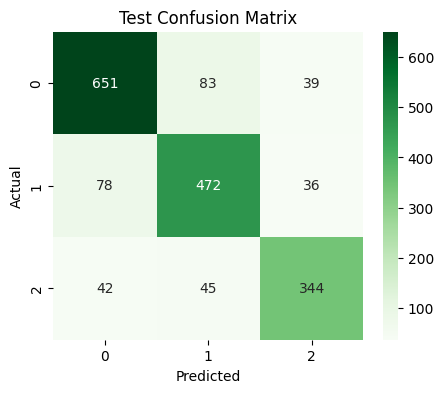

In [32]:
# Confusion Matrix

if 'label' in test_df.columns:
    test_labels = test_df['label'].values
    cm_test = confusion_matrix(test_labels, preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.show()
else:
    print("No true labels in test set; cannot compute confusion matrix for test data.")
